# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on Sagemaker studio with the following resources: 

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` instance

## Data Staging(ETL):

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system


### 1. Import the required resources:

In [187]:
!pip install jsonlines --quiet

In [262]:
import requests
import tarfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.serializers import IdentitySerializer
import base64
import random
import json
import jsonlines
from sagemaker.s3 import S3Downloader
import time
import glob
import plotly.express as px

In [2]:
session = sagemaker.session.Session()

bucket= 'srs-udacity-aws-2022'
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role =  get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: srs-udacity-aws-2022
AWS Region: us-east-1
RoleArn: arn:aws:iam::628477620632:role/service-role/AmazonSageMaker-ExecutionRole-20220219T175720


### 2. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [4]:
def extract_cifar_data(url, filename="cifar.tar.gz"):
    """
    A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    r = requests.get(url, allow_redirects=True)
    
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return filename
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

'cifar.tar.gz'

### 3. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [5]:
with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [6]:
with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [7]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [8]:
len(dataset_train[b'data'][0])

3072

In [9]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [10]:
# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))
len(combined)

32

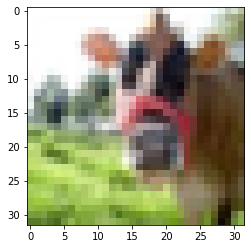

In [11]:
plt.imshow(combined)

For a more concise version, consider the following:

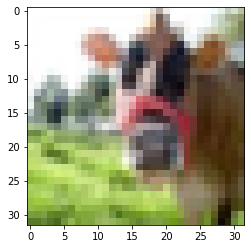

In [12]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [13]:
dataset_meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [14]:
print(len(dataset_train[b'fine_labels'])), print(len(dataset_meta[b'fine_label_names']))

50000
100


(None, None)

In [15]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [16]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


In [17]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [18]:
df = pd.DataFrame(dataset_meta[b'fine_label_names'], columns =  ['label_names'])
df[df.label_names.isin([b'bicycle',b'motorcycle'])]

,label_names
8,b'bicycle'
48,b'motorcycle'


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [19]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})
df_train.head(2)

,filenames,labels,row
0,b'bos_taurus_s_000507.png',19,0
1,b'stegosaurus_s_000125.png',29,1


In [20]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train.labels.isin([8,48])].copy()

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test.labels.isin([8,48])].copy()

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [21]:
df_train["labels"].unique(),df_train.shape

(array([ 8, 48]), (1000, 3))

In [22]:
df_train.head(2)

,filenames,labels,row
16,bike_s_000682.png,8,16
30,bike_s_000127.png,8,30


Now that the data is filtered for just our classes, we can save all our images.

In [23]:
!mkdir ./train
!mkdir ./test

In [24]:
def save_images(df, df2, path):
    for i in df["row"]:
        img = df2[b'data'][i]
        target = np.dstack((
        img[0:1024].reshape(32,32),
        img[1024:2048].reshape(32,32),
        img[2048:].reshape(32,32)
        ))
        plt.imsave(path+df['filenames'][i], target)
    return True

In [25]:
save_images(df_train, dataset_train, './train/')
save_images(df_test, dataset_test, './test/')

True

### 4. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

With this data we can easily sync your data up into S3!

In [26]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000035.png to s3://srs-udacity-aws-2022/train/bicycle_s_000035.png
upload: train/bicycle_s_000147.png to s3://srs-udacity-aws-2022/train/bicycle_s_000147.png
upload: train/bicycle_s_000021.png to s3://srs-udacity-aws-2022/train/bicycle_s_000021.png
upload: train/bicycle_s_000038.png to s3://srs-udacity-aws-2022/train/bicycle_s_000038.png
upload: train/bicycle_s_000039.png to s3://srs-udacity-aws-2022/train/bicycle_s_000039.png
upload: train/bicycle_s_000017.png to s3://srs-udacity-aws-2022/train/bicycle_s_000017.png
upload: train/bicycle_s_000124.png to s3://srs-udacity-aws-2022/train/bicycle_s_000124.png
upload: train/bicycle_s_000071.png to s3://srs-udacity-aws-2022/train/bicycle_s_000071.png
upload: train/bicycle_s_000051.png to s3://srs-udacity-aws-2022/train/bicycle_s_000051.png
upload: train/bicycle_s_000149.png to s3://srs-udacity-aws-2022/train/bicycle_s_000149.png
upload: train/bicycle_s_000066.png to s3://srs-udacity-aws-2022/train/bicycle_s_000066.png

upload: train/bicycle_s_002049.png to s3://srs-udacity-aws-2022/train/bicycle_s_002049.png
upload: train/bicycle_s_002222.png to s3://srs-udacity-aws-2022/train/bicycle_s_002222.png
upload: train/bicycle_s_002258.png to s3://srs-udacity-aws-2022/train/bicycle_s_002258.png
upload: train/bicycle_s_002100.png to s3://srs-udacity-aws-2022/train/bicycle_s_002100.png
upload: train/bicycle_s_002299.png to s3://srs-udacity-aws-2022/train/bicycle_s_002299.png
upload: train/bicycle_s_002338.png to s3://srs-udacity-aws-2022/train/bicycle_s_002338.png
upload: train/bicycle_s_002218.png to s3://srs-udacity-aws-2022/train/bicycle_s_002218.png
upload: train/bicycle_s_001956.png to s3://srs-udacity-aws-2022/train/bicycle_s_001956.png
upload: train/bicycle_s_002373.png to s3://srs-udacity-aws-2022/train/bicycle_s_002373.png
upload: train/bicycle_s_002400.png to s3://srs-udacity-aws-2022/train/bicycle_s_002400.png
upload: train/bicycle_s_002374.png to s3://srs-udacity-aws-2022/train/bicycle_s_002374.png

upload: train/bike_s_001415.png to s3://srs-udacity-aws-2022/train/bike_s_001415.png   
upload: train/bike_s_001462.png to s3://srs-udacity-aws-2022/train/bike_s_001462.png   
upload: train/bike_s_001572.png to s3://srs-udacity-aws-2022/train/bike_s_001572.png   
upload: train/bike_s_001517.png to s3://srs-udacity-aws-2022/train/bike_s_001517.png   
upload: train/bike_s_001414.png to s3://srs-udacity-aws-2022/train/bike_s_001414.png   
upload: train/bike_s_001613.png to s3://srs-udacity-aws-2022/train/bike_s_001613.png   
upload: train/bike_s_001380.png to s3://srs-udacity-aws-2022/train/bike_s_001380.png   
upload: train/bike_s_001592.png to s3://srs-udacity-aws-2022/train/bike_s_001592.png   
upload: train/bike_s_001679.png to s3://srs-udacity-aws-2022/train/bike_s_001679.png   
upload: train/bike_s_001739.png to s3://srs-udacity-aws-2022/train/bike_s_001739.png   
upload: train/bike_s_001683.png to s3://srs-udacity-aws-2022/train/bike_s_001683.png   
upload: train/bike_s_001519.png 

upload: train/dirt_bike_s_000134.png to s3://srs-udacity-aws-2022/train/dirt_bike_s_000134.png
upload: train/minibike_s_000020.png to s3://srs-udacity-aws-2022/train/minibike_s_000020.png
upload: train/minibike_s_000010.png to s3://srs-udacity-aws-2022/train/minibike_s_000010.png
upload: train/dirt_bike_s_000017.png to s3://srs-udacity-aws-2022/train/dirt_bike_s_000017.png
upload: train/minibike_s_000022.png to s3://srs-udacity-aws-2022/train/minibike_s_000022.png
upload: train/dirt_bike_s_000119.png to s3://srs-udacity-aws-2022/train/dirt_bike_s_000119.png
upload: train/minibike_s_000011.png to s3://srs-udacity-aws-2022/train/minibike_s_000011.png
upload: train/minibike_s_000035.png to s3://srs-udacity-aws-2022/train/minibike_s_000035.png
upload: train/minibike_s_000036.png to s3://srs-udacity-aws-2022/train/minibike_s_000036.png
upload: train/minibike_s_000099.png to s3://srs-udacity-aws-2022/train/minibike_s_000099.png
upload: train/minibike_s_000064.png to s3://srs-udacity-aws-2022

upload: train/minibike_s_001157.png to s3://srs-udacity-aws-2022/train/minibike_s_001157.png
upload: train/minibike_s_001250.png to s3://srs-udacity-aws-2022/train/minibike_s_001250.png
upload: train/minibike_s_001270.png to s3://srs-udacity-aws-2022/train/minibike_s_001270.png
upload: train/minibike_s_001279.png to s3://srs-udacity-aws-2022/train/minibike_s_001279.png
upload: train/minibike_s_001016.png to s3://srs-udacity-aws-2022/train/minibike_s_001016.png
upload: train/minibike_s_001294.png to s3://srs-udacity-aws-2022/train/minibike_s_001294.png
upload: train/minibike_s_001345.png to s3://srs-udacity-aws-2022/train/minibike_s_001345.png
upload: train/minibike_s_001261.png to s3://srs-udacity-aws-2022/train/minibike_s_001261.png
upload: train/minibike_s_001249.png to s3://srs-udacity-aws-2022/train/minibike_s_001249.png
upload: train/minibike_s_001417.png to s3://srs-udacity-aws-2022/train/minibike_s_001417.png
upload: train/minibike_s_001344.png to s3://srs-udacity-aws-2022/train

upload: train/motorbike_s_000009.png to s3://srs-udacity-aws-2022/train/motorbike_s_000009.png
upload: train/motorbike_s_000022.png to s3://srs-udacity-aws-2022/train/motorbike_s_000022.png
upload: train/motorbike_s_000035.png to s3://srs-udacity-aws-2022/train/motorbike_s_000035.png
upload: train/motorbike_s_000058.png to s3://srs-udacity-aws-2022/train/motorbike_s_000058.png
upload: train/motorbike_s_000041.png to s3://srs-udacity-aws-2022/train/motorbike_s_000041.png
upload: train/motorbike_s_000068.png to s3://srs-udacity-aws-2022/train/motorbike_s_000068.png
upload: train/motorbike_s_000021.png to s3://srs-udacity-aws-2022/train/motorbike_s_000021.png
upload: train/motorbike_s_000106.png to s3://srs-udacity-aws-2022/train/motorbike_s_000106.png
upload: train/motorbike_s_000115.png to s3://srs-udacity-aws-2022/train/motorbike_s_000115.png
upload: train/motorbike_s_000124.png to s3://srs-udacity-aws-2022/train/motorbike_s_000124.png
upload: train/motorbike_s_000119.png to s3://srs-u

upload: train/motorcycle_s_000340.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000340.png
upload: train/motorcycle_s_000347.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000347.png
upload: train/motorcycle_s_000284.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000284.png
upload: train/motorcycle_s_000407.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000407.png
upload: train/motorcycle_s_000418.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000418.png
upload: train/motorcycle_s_000339.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000339.png
upload: train/motorcycle_s_000417.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000417.png
upload: train/motorcycle_s_000422.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000422.png
upload: train/motorcycle_s_000430.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000430.png
upload: train/motorcycle_s_000423.png to s3://srs-udacity-aws-2022/train/motorcycle_s_000423.png
upload: train/motorcycle_s_000

upload: train/motorcycle_s_001180.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001180.png
upload: train/motorcycle_s_001176.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001176.png
upload: train/motorcycle_s_001181.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001181.png
upload: train/motorcycle_s_001182.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001182.png
upload: train/motorcycle_s_001209.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001209.png
upload: train/motorcycle_s_001205.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001205.png
upload: train/motorcycle_s_001183.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001183.png
upload: train/motorcycle_s_001063.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001063.png
upload: train/motorcycle_s_001213.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001213.png
upload: train/motorcycle_s_001236.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001236.png
upload: train/motorcycle_s_001

upload: train/motorcycle_s_002143.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002143.png
upload: train/motorcycle_s_001896.png to s3://srs-udacity-aws-2022/train/motorcycle_s_001896.png
upload: train/motorcycle_s_002192.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002192.png
upload: train/motorcycle_s_002214.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002214.png
upload: train/motorcycle_s_002197.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002197.png
upload: train/motorcycle_s_002193.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002193.png
upload: train/motorcycle_s_002153.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002153.png
upload: train/motorcycle_s_002221.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002221.png
upload: train/motorcycle_s_002183.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002183.png
upload: train/motorcycle_s_002222.png to s3://srs-udacity-aws-2022/train/motorcycle_s_002222.png
upload: train/motorcycle_s_002

upload: train/ordinary_bicycle_s_000432.png to s3://srs-udacity-aws-2022/train/ordinary_bicycle_s_000432.png
upload: train/safety_bicycle_s_000303.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000303.png
upload: train/safety_bicycle_s_000193.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000193.png
upload: train/safety_bicycle_s_000196.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000196.png
upload: train/safety_bicycle_s_000322.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000322.png
upload: train/safety_bicycle_s_000324.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000324.png
upload: train/safety_bicycle_s_000261.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000261.png
upload: train/safety_bicycle_s_000207.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000207.png
upload: train/safety_bicycle_s_000348.png to s3://srs-udacity-aws-2022/train/safety_bicycle_s_000348.png
upload: train/safety_bicycle_s_000359.png to s3://s

upload: train/safety_bike_s_000914.png to s3://srs-udacity-aws-2022/train/safety_bike_s_000914.png
upload: train/safety_bike_s_001371.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001371.png
upload: train/safety_bike_s_000950.png to s3://srs-udacity-aws-2022/train/safety_bike_s_000950.png
upload: train/safety_bike_s_001257.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001257.png
upload: train/safety_bike_s_001148.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001148.png
upload: train/safety_bike_s_001338.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001338.png
upload: train/safety_bike_s_001474.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001474.png
upload: train/safety_bike_s_001472.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001472.png
upload: train/safety_bike_s_001560.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001560.png
upload: train/safety_bike_s_001590.png to s3://srs-udacity-aws-2022/train/safety_bike_s_001590.png
upload: tr

upload: test/motorcycle_s_000530.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000530.png
upload: test/motorcycle_s_000049.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000049.png
upload: test/motorcycle_s_000450.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000450.png
upload: test/motorcycle_s_000602.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000602.png
upload: test/motorcycle_s_000512.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000512.png
upload: test/motorcycle_s_000352.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000352.png
upload: test/motorcycle_s_000679.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000679.png
upload: test/motorcycle_s_000739.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000739.png
upload: test/motorcycle_s_000615.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000615.png
upload: test/motorcycle_s_000825.png to s3://srs-udacity-aws-2022/test/motorcycle_s_000825.png
upload: test/motorcycle_s_000876.png to s3://srs-u

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [27]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [28]:
# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [29]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = image_uris.retrieve('image-classification', session.boto_region_name)
s3_output_location = f"s3://{bucket}/models/image_model"

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p2.xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [35]:
img_classifier_model=sagemaker.estimator.Estimator(algo_image,
                                                   role,
                                                   instance_count=1,
                                                   instance_type='ml.p2.xlarge',     
                                                   output_path=s3_output_location,
                                                   sagemaker_session=session
                                                  )

We can also set a few key hyperparameters and define the inputs for our model:

In [36]:
img_classifier_model.set_hyperparameters(image_shape='3,32,32',
                                         num_classes=2, 
                                         num_training_samples= 1000
                                        )

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [37]:
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [39]:
img_classifier_model.fit(model_inputs)

2022-04-20 08:49:11 Starting - Starting the training job...ProfilerReport-1650444551: InProgress
...
2022-04-20 08:50:00 Starting - Preparing the instances for training.........
2022-04-20 08:51:41 Downloading - Downloading input data...
2022-04-20 08:52:02 Training - Downloading the training image.........
2022-04-20 08:53:41 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/20/2022 08:53:47 INFO 140246797633344] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[04/20/2022 08:53:47 INFO 140246797633344] Merging with provided configuration from 

[04/20/2022 08:57:06 INFO 140246797633344] Epoch[9] Batch [20]#011Speed: 57.059 samples/sec#011accuracy=0.827381
[04/20/2022 08:57:11 INFO 140246797633344] Epoch[9] Train-accuracy=0.824597
[04/20/2022 08:57:11 INFO 140246797633344] Epoch[9] Time cost=16.696
[04/20/2022 08:57:13 INFO 140246797633344] Epoch[9] Validation-accuracy=0.765625
[04/20/2022 08:57:25 INFO 140246797633344] Epoch[10] Batch [20]#011Speed: 57.515 samples/sec#011accuracy=0.827381
[04/20/2022 08:57:30 INFO 140246797633344] Epoch[10] Train-accuracy=0.820565
[04/20/2022 08:57:30 INFO 140246797633344] Epoch[10] Time cost=16.600
[04/20/2022 08:57:31 INFO 140246797633344] Epoch[10] Validation-accuracy=0.734375
[04/20/2022 08:57:43 INFO 140246797633344] Epoch[11] Batch [20]#011Speed: 57.570 samples/sec#011accuracy=0.828869
[04/20/2022 08:57:49 INFO 140246797633344] Epoch[11] Train-accuracy=0.839718
[04/20/2022 08:57:49 INFO 140246797633344] Epoch[11] Time cost=16.589
[04/20/2022 08:57:50 INFO 140246797633344] Epoch[11] Vali

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [43]:
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [44]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1, instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

---------------!image-classification-2022-04-20-09-06-00-803


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [45]:
predictor = sagemaker.predictor.Predictor(endpoint)

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [48]:
predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)
print(inference)

b'[0.8762310147285461, 0.12376897037029266]'


Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.87, 0.12]'` indicates the probability of being a bike is 91% and being a motorcycle is 87%.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [153]:
def generate_test_case():
    s3 = boto3.resource('s3')
    objects = s3.Bucket(bucket).objects.filter(Prefix = "test")
    obj = random.choice([x.key for x in objects])
    print(obj)
    return {
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    }
data = generate_test_case()

test/bike_s_001073.png


In [123]:
generate_test_case()['s3_key']

'test/motorcycle_s_000685.png'

In [154]:
time.sleep(2.4)

In [175]:
for i in range(1000):
    time.sleep(1)
    predictor.serializer = IdentitySerializer("image/png")
    img  = generate_test_case()['s3_key']
    with open(f"./{img}", "rb") as f:
        payload = f.read()
    inference = predictor.predict(payload)
    print(inference)

test/bike_s_000941.png
b'[0.9942302703857422, 0.005769702605903149]'
test/safety_bike_s_000192.png
b'[0.340427964925766, 0.6595720648765564]'
test/bicycle_s_000059.png
b'[0.09754893183708191, 0.9024510383605957]'
test/motorcycle_s_001892.png
b'[0.2711452841758728, 0.728854775428772]'
test/motorcycle_s_000427.png
b'[0.18719936907291412, 0.8128006458282471]'
test/minibike_s_000801.png
b'[0.021833250299096107, 0.9781666994094849]'
test/motorcycle_s_000446.png
b'[0.15404099225997925, 0.8459590077400208]'
test/minibike_s_002173.png
b'[0.04909737408161163, 0.9509026408195496]'
test/velocipede_s_000041.png
b'[0.9644022583961487, 0.03559769690036774]'
test/motorcycle_s_001955.png
b'[0.012719702906906605, 0.9872803092002869]'
test/motorcycle_s_000797.png
b'[0.6230524182319641, 0.3769475519657135]'
test/minibike_s_000075.png
b'[0.13693979382514954, 0.8630602359771729]'
test/motorcycle_s_001936.png
b'[0.9944900274276733, 0.005509958602488041]'
test/bike_s_000694.png
b'[0.7132983803749084, 0.28670

test/bike_s_000041.png
b'[0.05254283547401428, 0.9474571943283081]'
test/motorcycle_s_001906.png
b'[0.013688717968761921, 0.9863112568855286]'
test/motorcycle_s_002112.png
b'[0.00017473151092417538, 0.9998252987861633]'
test/minibike_s_000055.png
b'[0.0003047669888474047, 0.9996953010559082]'
test/safety_bike_s_000699.png
b'[0.9626290202140808, 0.037370964884757996]'
test/motorcycle_s_001782.png
b'[0.310091108083725, 0.6899088621139526]'
test/motorcycle_s_001906.png
b'[0.013688717968761921, 0.9863112568855286]'
test/motorbike_s_000135.png
b'[0.15262459218502045, 0.8473753929138184]'
test/motorcycle_s_001249.png
b'[0.1413567215204239, 0.8586432337760925]'
test/motorcycle_s_001936.png
b'[0.9944900274276733, 0.005509958602488041]'
test/bike_s_000071.png
b'[0.97756427526474, 0.022435687482357025]'
test/motorbike_s_000324.png
b'[0.6063210368156433, 0.3936789333820343]'
test/motorcycle_s_000679.png
b'[0.02752191759645939, 0.9724781513214111]'
test/motorcycle_s_002112.png
b'[0.000174731510924

test/moped_s_000064.png
b'[0.4989433288574219, 0.5010566115379333]'
test/motorcycle_s_001906.png
b'[0.013688717968761921, 0.9863112568855286]'
test/bicycle_s_001218.png
b'[0.8936870694160461, 0.10631288588047028]'
test/minibike_s_000288.png
b'[0.3311898410320282, 0.6688101887702942]'
test/velocipede_s_001232.png
b'[0.9976264834403992, 0.0023735486902296543]'
test/motorcycle_s_000063.png
b'[0.002798698376864195, 0.9972013235092163]'
test/motorbike_s_000629.png
b'[0.7806129455566406, 0.219387024641037]'
test/minibike_s_000309.png
b'[0.00010692579235183075, 0.999893069267273]'
test/motorcycle_s_001971.png
b'[0.06209553778171539, 0.9379044771194458]'
test/safety_bike_s_001088.png
b'[0.835294783115387, 0.164705291390419]'
test/minibike_s_000792.png
b'[0.047498974949121475, 0.9525010585784912]'
test/velocipede_s_001201.png
b'[0.9526661038398743, 0.047333888709545135]'
test/bike_s_002009.png
b'[0.4985572397708893, 0.5014427900314331]'
test/minibike_s_001732.png
b'[0.009907273575663567, 0.9900

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "unable to evaluate payload provided". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/image-classification-2022-04-20-09-06-00-803 in account 628477620632 for more information.

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [176]:
# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://srs-udacity-aws-2022/data_capture/image-classification-2022-04-20-09-06-00-803/AllTraffic/2022/04/23/07/"

S3Downloader.download(data_path, "captured_data")

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

Now we can extract the data from each of the source files:

In [ ]:
def label_encoder (x):
    if x >= 0.5:
        return 'motorcycle'
    elif x < 0.5:
        return 'bicycle'

In [266]:
df = pd.DataFrame()

for name in glob.glob('./captured_data/*.jsonl'):
    df1 = pd.read_json(path_or_buf=file_path, lines=True)
    df = df.append(df1)
    print(name)
    print(df.shape)
df['time_stamp'] = df.eventMetadata.apply(lambda x: x["inferenceTime"])
df['time_stamp'] = pd.to_datetime(df['time_stamp'] )
df['prob_motorcycle'] = df.captureData.apply(lambda x: json.loads(x['endpointOutput']['data'])[1])
df['lable'] = df.prob_motorcycle.apply(label_encoder)

print(df.shape)
df.head(2)

./captured_data/21-58-290-36b2080d-5be8-4780-8afd-17137628c973.jsonl
(50, 3)
./captured_data/25-00-749-69cef804-b787-44eb-8a5a-2303e4b76b20.jsonl
(100, 3)
./captured_data/26-01-738-d4a459e1-0196-469d-90cd-b771c054cc3e.jsonl
(150, 3)
./captured_data/52-57-229-65265b52-0a9e-4b17-9d26-bbf22ec0bd82.jsonl
(200, 3)
./captured_data/51-56-754-911cae9d-34b0-4cd3-b271-46238ba9094a.jsonl
(250, 3)
./captured_data/23-59-560-b1119209-9a21-4bf2-9940-5b4952a2d6b7.jsonl
(300, 3)
./captured_data/27-02-395-bf8369f0-e570-4589-9a5e-afd7d46f9f30.jsonl
(350, 3)
./captured_data/20-57-257-ec9a22e7-3f95-4130-9cc0-46195fb7dd87.jsonl
(400, 3)
./captured_data/22-58-366-65376284-fcd7-43d0-8608-aafe02a68000.jsonl
(450, 3)
(450, 6)


,captureData,eventMetadata,eventVersion,time_stamp,prob_motorcycle,lable
0,{'endpointInput': {'observedContentType': 'ima...,{'eventId': '533c6934-40ca-4d35-ad19-89a50c281...,0,2022-04-23 07:25:00+00:00,0.021556,bicycle
1,{'endpointInput': {'observedContentType': 'ima...,{'eventId': '46dcf39a-cded-4a57-b1b4-3a548c825...,0,2022-04-23 07:25:01+00:00,0.903406,motorcycle


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [268]:
df_plot = pd.DataFrame(df.lable.value_counts())
df_plot.reset_index(inplace = True)

In [269]:
fig = px.bar(df_plot, x='index', y='lable')
fig.show()

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

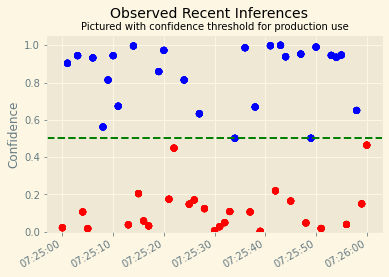

In [250]:
# Populate the data for the x and y axis
x = df.time_stamp.to_list()
y = df.prob_motorcycle.to_list()


# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.5 else 'b' for k in y ])
plt.axhline(y=0.5, color='g', linestyle='--')
plt.ylim(bottom=0)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()